In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load Dataset

In [4]:
# Get data from UCI
#!wget https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv
#Boston Dataset variables overview
# Variables
# There are 14 attributes in each case of the dataset. They are:
# CRIM - per capita crime rate by town
# ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
# INDUS - proportion of non-retail business acres per town.
# CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
# NOX - nitric oxides concentration (parts per 10 million)
# RM - average number of rooms per dwelling
# AGE - proportion of owner-occupied units built prior to 1940
# DIS - weighted distances to five Boston employment centres
# RAD - index of accessibility to radial highways
# TAX - full-value property-tax rate per $10,000
# PTRATIO - pupil-teacher ratio by town
# B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# LSTAT - % lower status of the population
# MEDV - Median value of owner-occupied homes in $1000's

# Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000)

# Load the dataset
data = pd.read_csv("BostonHousing.csv")

# EDA

In [5]:
#Boston dataset overview
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
# Boston Dataset info summary
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


# Separating features from the target variable

In [13]:
# Separate features (X) and target variable (y)
# The target 'medv' is the median value of owner-occupied homes in $1000s.(medv is our prediction target)

X = data.drop('medv', axis=1).values  # All columns except 'medv' are features - drop medv and remain with other columns
y = data['medv'].values.reshape(-1, 1) # Reshape y to be a 2D column vector for consistency

#  Preprocessing and model Definition

In [5]:
# Normalization is critical for gradient-based optimization as it ensures all features
# contribute equally to the loss function, leading to faster and more stable convergence.
scaler = StandardScaler()
X = scaler.fit_transform(X) # Transforms features to have mean=0 and standard deviation=1

# PyTorch models require inputs to be tensors. Using .float() ensures the data type is compatible.
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Model Definition
class LinearRegressionModel(nn.Module):
    """A simple linear regression model."""
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # Define a single linear layer that maps input_dim features to output_dim predictions
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # The forward pass defines how input data is transformed into an output prediction
        return self.linear(x)

# Instantiate the model
model = LinearRegressionModel(X.shape[1], 1) # input_dim = number of features, output_dim = 1 (price)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error, suitable for regression tasks
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic Gradient Descent optimizer

# Training Loop

In [6]:
epochs = 500
# List to track the loss at each epoch for visualization
losses = []


for epoch in range(epochs):
    # Set model to training mode (important for layers like dropout/batchnorm)
    model.train()

    # Clear previous gradients; otherwise, they accumulate
    optimizer.zero_grad()

    # Forward Pass: Compute predicted y by passing X to the model
    y_pred = model(X_tensor)

    # Compute Loss: Calculate the MSE between predictions and true labels
    loss = criterion(y_pred, y_tensor)

    # Backward Pass: Compute gradients of the loss w.r.t. all model parameters
    loss.backward()

    # Update Parameters: Perform a single optimization step
    optimizer.step()

    # Store the loss for this epoch
    losses.append(loss.item())

    # Print progress every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/500], Loss: 33.1437
Epoch [200/500], Loss: 23.0431
Epoch [300/500], Loss: 22.4930
Epoch [400/500], Loss: 22.2786
Epoch [500/500], Loss: 22.1546


The results from training clearly demonstrate that increasing the number of epochs leads to a decrease in the model’s loss value. As seen in the printed losses, the mean squared error (MSE) consistently drops from 33. at epoch 100 to 22. at epoch 500, indicating that the model’s predictions are becoming progressively closer to the actual housing prices. This trend verifies the principle of gradient-based learning with each training epoch, the model iteratively adjusts its weights to minimize prediction error. However, after several hundred epochs, the improvement becomes marginal, suggesting that the model is approaching convergence. In conclusion, training the model for more epochs effectively reduces loss, but the benefit diminishes as the model stabilizes around its optimal parameter values.


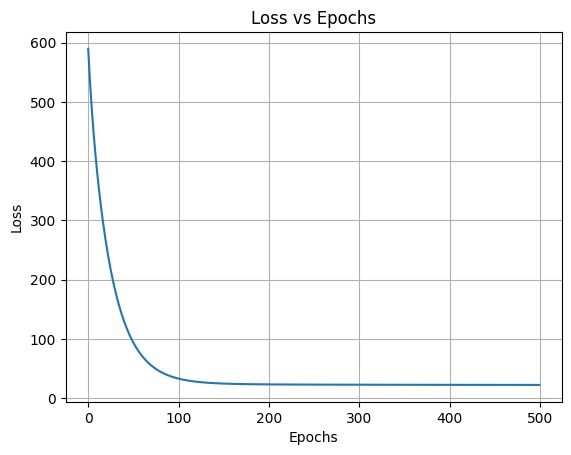

In [7]:
# Loss vs Epoch Plot
plt.plot(losses)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()